**LONG SHORT TERM MEMORY NETWORK (LSTM)**

**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

**Data Cleaning**

In [3]:
dune_df = pd.read_csv('nft_dune_extraction.csv')
opensea_df = pd.read_csv('nft_opensea_extraction.csv')

df = dune_df.merge(opensea_df, on='token_id', how='left')

# Data cleaning and preparation
df.rename(columns={'amount_original': 'trade_price'}, inplace=True)
df = df[df['trade_price'] != '<nil>'].copy()
df['trade_price'] = df['trade_price'].astype(float)
df['block_time'] = pd.to_datetime(df['block_time'])
df['block_date'] = pd.to_datetime(df['block_date'])
df['block_month'] = pd.to_datetime(df['block_month'])
df = df[(df['trade_price'] <= df['price_max_eth']) & (df['trade_price'] >= df['price_min_eth'])].copy()

# Handle missing values for optional traits
optional_traits = {}
for i, v in opensea_df.isna().sum().items():
    if v > 0:
        trait = i.split("_")[0]
        optional_traits[trait] = v

for trait, count in optional_traits.items():
    opensea_df[trait+"_value"] = opensea_df[trait+"_value"].fillna("Empty")
    opensea_df[trait+"_count"] = opensea_df[trait+"_count"].fillna(count).astype(int)

# Merge cleaned data with traits data
cleaned = df.merge(opensea_df, on='token_id', how='left')

# Print the number of NaN values in each column
print("Number of NaN values in each column in cleaned DataFrame:")
print(cleaned.isna().sum())

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
columns_to_encode = ['project', 'version', 'collection', 'token_standard', 'trade_type', 'trade_category', 'evt_type', 'currency_symbol', 'Background_value_x', 'Hat_value_x', 'Mouth_value_x', 'Eyes_value_x', 'Fur_value_x', 'Clothes_value_x', 'Earring_value_x']
for col in columns_to_encode:
    if col in cleaned.columns:
        cleaned[col] = le.fit_transform(cleaned[col].astype(str))

cleaned['amount_usd'] = pd.to_numeric(cleaned['amount_usd'], errors='coerce')

# Drop unnecessary columns
#cleaned.drop(["tx_hash"], axis=1, inplace=True)

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
columns_to_encode = ['project', 'version', 'collection', 'token_standard', 'trade_type', 'trade_category', 'evt_type', 'currency_symbol', 'Background_value_x', 'Hat_value_x', 'Mouth_value_x', 'Eyes_value_x', 'Fur_value_x', 'Clothes_value_x', 'Earring_value_x']
for col in columns_to_encode:
    if col in cleaned.columns:
        cleaned[col] = le.fit_transform(cleaned[col].astype(str))

cleaned['amount_usd'] = pd.to_numeric(cleaned['amount_usd'], errors='coerce')

# Drop unnecessary columns
cleaned.drop(["tx_hash"], axis=1, inplace=True)

Number of NaN values in each column in cleaned DataFrame:
Unnamed: 0_x              0
project                   0
version                   0
block_date                0
block_month               0
block_time                0
token_id                  0
collection                0
amount_usd                0
token_standard            0
trade_type                0
number_of_items           0
trade_category            0
evt_type                  0
trade_price               0
currency_symbol           0
tx_hash                   0
volume_eth                0
price_p5_eth              0
price_min_eth             0
price_max_eth             0
Unnamed: 0_y              0
rarity_rank_x             0
Background_value_x        0
Background_count_x        0
Hat_value_x            9944
Hat_count_x            9944
Mouth_value_x             0
Mouth_count_x             0
Eyes_value_x              0
Eyes_count_x              0
Fur_value_x               0
Fur_count_x               0
Clothes_value_x   

**Train - Test Split**

In [4]:

# Adjust the feature columns based on the available columns
feature_columns = [
    'volume_eth', 'price_p5_eth', 'price_max_eth', 'price_min_eth',
    'Background_count_x', 'Mouth_count_x', 'Eyes_count_x', 'Fur_count_x',
    'Hat_count_x', 'Clothes_count_x', 'Earring_count_x'
]
target_column = 'trade_price'

# Creating the dataset
X = cleaned[feature_columns].values
y = cleaned[target_column].values

# Check for NaN and infinite values in the features and target
print(f"NaN values in X: {np.isnan(X).sum()}")
print(f"NaN values in y: {np.isnan(y).sum()}")
print(f"Infinite values in X: {np.isinf(X).sum()}")
print(f"Infinite values in y: {np.isinf(y).sum()}")

# Replace NaN and infinite values with zeros
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)

# Scale the features and target variable
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape data for LSTM (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)

NaN values in X: 49580
NaN values in y: 0
Infinite values in X: 0
Infinite values in y: 0


**LSTM**

In [5]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             12400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32651 (127.54 KB)
Trainable params: 32651 (127.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
868/868

**Results**

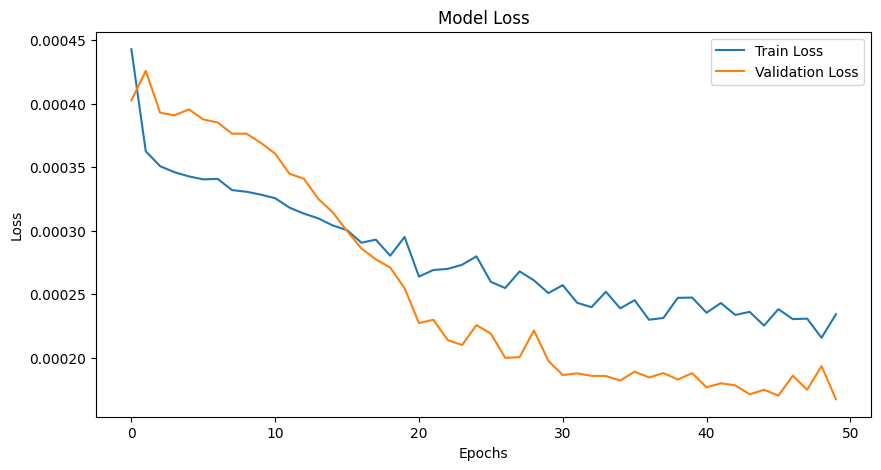

272/272 [==============================] - 1s 2ms/step
Mean Squared Error: 368.72427605875487
Mean Absolute Error: 6.287387900590264


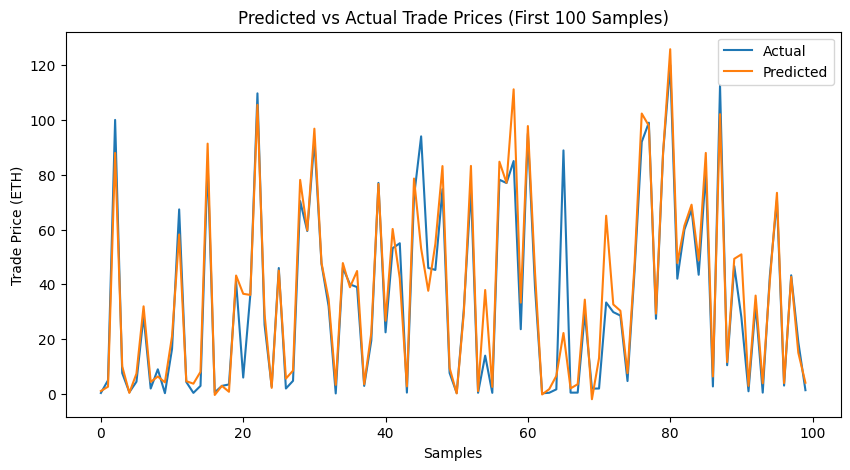

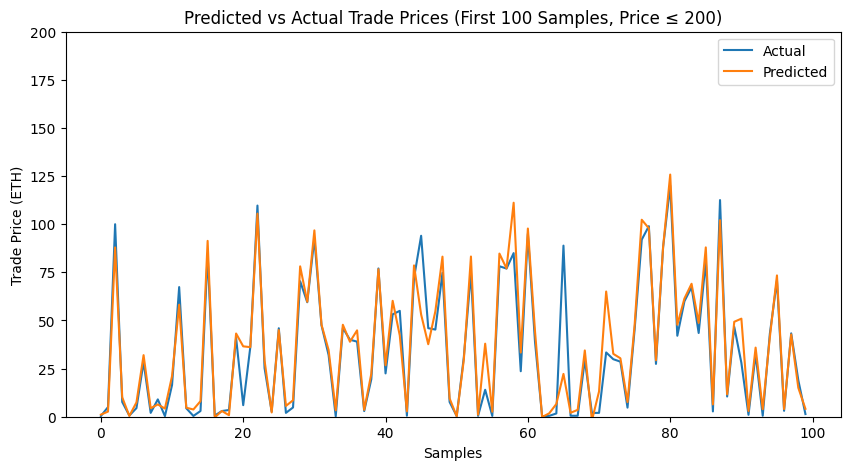

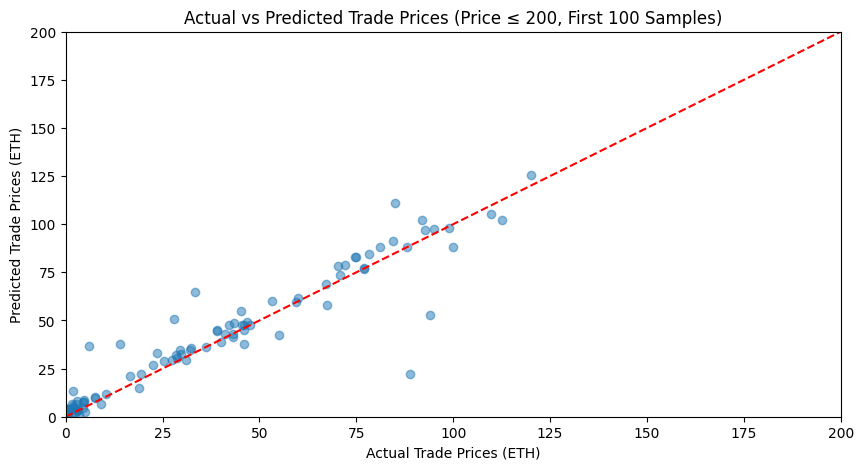

In [6]:
# Plot the training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inverse = scaler_y.inverse_transform(y_pred)
y_test_inverse = scaler_y.inverse_transform(y_test)

# Calculate additional performance metrics
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plot predictions vs actual for the first 100 samples
plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(y_pred_inverse[:100], label='Predicted')
plt.title('Predicted vs Actual Trade Prices (First 100 Samples)')
plt.xlabel('Samples')
plt.ylabel('Trade Price (ETH)')
plt.legend()
plt.show()

# Plot predictions vs actual for the first 100 samples with prices up to 200
plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(y_pred_inverse[:100], label='Predicted')
plt.title('Predicted vs Actual Trade Prices (First 100 Samples, Price ≤ 200)')
plt.xlabel('Samples')
plt.ylabel('Trade Price (ETH)')
plt.ylim(0, 200)
plt.legend()
plt.show()

# Scatter plot of actual vs predicted values for the first 100 samples with prices up to 200
plt.figure(figsize=(10, 5))
plt.scatter(y_test_inverse[:100], y_pred_inverse[:100], alpha=0.5)
plt.plot([0, 200], [0, 200], 'r--')
plt.title('Actual vs Predicted Trade Prices (Price ≤ 200, First 100 Samples)')
plt.xlabel('Actual Trade Prices (ETH)')
plt.ylabel('Predicted Trade Prices (ETH)')
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.show()
